In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Adolfo Arana Espíritu Santo
#22/11/2022
#El programa es una clase con la metodología estudiada en el libro Hands-On Machine Learning (el de la 
# salamandra). Abarca lo explicado en el capítulo 2, 3, 4 y 7
#Con esta clase se espera sistematizar la seleciión del algoritmo
#Se asume que los datos están listos para meterse al algoritmo seleccionado

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from numpy.random import RandomState
import pandas as pd

class Algoritmo:
    def __init__(self, model,X,y):
        self.model = model #El modelo a utilizar para la predicción
        self.X = X #Todos los atributos
        self.y = y #Todos los targets
        self.final_model = model

    def particionDatos(self,r = 32, s = 0.2):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = s, random_state = r, stratify = self.y)
        #stratify lo dejamos en y porque así nos aseguramos de tener datasets balanceados según las distriucionesde las variables
        return(X_train, X_test, y_train, y_test)
    
    def crossVal(self, X,y,k = 10, score = 'accuracy'):
        #Hace cross-validation
        scores = cross_val_score(self.model, X, y,scoring= score, cv=k) 
        #cv, además de formar los grupos, mantiene las proporciones del dataset
        print("Mean: ", scores.mean(), "\nSDV: ", scores.std())
    
    def hpTunningGSCV(self,modelo,param_grid,X_train,y_train,X_test,name = 'modelo', CV = 10):
        #Tuneamos modelo
        grid_search = GridSearchCV(modelo, param_grid, cv=CV)
        grid_search.fit(X_train, y_train)
        print(grid_search.best_params_)
        print(grid_search.best_estimator_)
        self.final_model = grid_search.best_estimator_
        joblib.dump(self.final_model, name +".pkl")
        return(self.final_model.predict(X_test))
    
    def evaluacionClasificacionMulti(self,y_test, labs, final_pred):
        #Matriz de confusión con múltiples categorías
        a = multilabel_confusion_matrix(y_test, final_pred, labels = labs)
        print("Matrices de confusión: ")
        print(a)
        final_prom_matrix = np.zeros((2,2))
        final_prom_matrix[0,0] = np.round(np.mean(a[:,0,0])) #Media de True Negative
        final_prom_matrix[0,1] = np.round(np.mean(a[:,0,1])) #Media de False Positive (se predijo que sí es pero no es)
        final_prom_matrix[1,0] = np.round(np.mean(a[:,1,0])) #Media de False Negative (se predijo que no es pero sí es)
        final_prom_matrix[1,1] = np.round(np.mean(a[:,1,1])) #Media de True Positive
        print('Promedio de matrices de confusión: ')
        print(final_prom_matrix)
        self.graficaClasificacion(a,labs)
    
    def evaluacionClasificacion(self, y_test, final_pred, size = (10,10)):
        #Matriz de confusión
        a = confusion_matrix(y_test, final_pred)
        print("Matriz de confusión")
        print(a)
        precision = (a[0,0])/(a[0,0] + a[1,0])
        recall = (a[0,0])/(a[0,0] + a[0,1])
        calcs = [(a[0,0] + a[1,1])/(a[0,0] + a[0,1] + a[1,0] + a[1,1]),
        precision,recall,(2*precision*recall)/(precision + recall)]
        return(calcs)
        
    def graficaClasificacion(self,a,labs, size = (10,10)):
        #Grafica matrices de confusión
        fig, axs = plt.subplots(2, 2, figsize= size)
        fig2, axs2 = plt.subplots(2, 2, figsize= size)
        precision = (a[:,0,0])/(a[:,0,0] + a[:,1,0])
        recall = (a[:,0,0])/(a[:,0,0] + a[:,0,1])
        calcs = [(a[:,0,0] + a[:,1,1])/(a[:,0,0] + a[:,0,1] + a[:,1,0] + a[:,1,1]),
        precision,recall,(2*precision*recall)/(precision + recall)]
        index = 0
        labels = [i for i in labs]
        titles = ["True Negative", "False Positive", 
        "False Negative", "True Positive"]
        titles2 = ["Accuracy", "Precision", "Recall", "F1"]
        final_metrics = np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                axs[i,j].bar(labels, a[:,i,j])
                axs2[i,j].bar(labels,calcs[index])
                axs[i, j].set_title(titles[index])
                axs2[i, j].set_title(titles2[index])
                index += 1
        final_metrics[0,0] = calcs[0].mean() 
        final_metrics[0,1] = precision.mean()
        final_metrics[1,0] = recall.mean()
        final_metrics[1,1] = calcs[3].mean()
        print('Accuracy', '\t', 'Recall')
        print('Precision', '\t', 'F1')
        print(final_metrics)

    def plot_learning_curves(self, X, y):
        #Hands-on Machine Learning, cap.4
        #Metric used: mean_squared_error for performance evaluation
        model = self.model
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        train_errors, val_errors = [], []
        for m in range(1, len(X_train)):
            model.fit(X_train[:m], y_train[:m])
            y_train_predict = model.predict(X_train[:m])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
        plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

    def votingEnsemble(self,est, X_train, y_train, vot = 'hard'):
        #Capítulo 7
        voting_clf = VotingClassifier(estimators=est,voting=vot)
        voting_clf.fit(X_train, y_train)
    
    def separacionDatos(X,y, s= 0.5,r = 32):
    #Aplica sólo para clasificación binaria
    #X son todos los features, y todas las categorías, s indica qué porcentaje del total de
    #las fallas (1) queremos tener en el train set, y r la semilla random, esto para garantizar la 
    #reproducibilidad


        rs = RandomState(r) #Iniciamos semilla
        index = y[y[y.columns[0]] == 1].index
        c = round(len(index)*s) #Cuenta cuántos datos sacaremos con 1
        cc = len(index) - c #Para dividir el set completo
        ran_index = rs.choice(index, c) #Saca c índices de manera aleatoria de todos los que tienen y = 1

        #Extraemos datos
        X_train = X.filter(items = ran_index, axis = 0) 
        y_train = y.filter(items = ran_index, axis = 0)
        ran_index = list(ran_index)

        #Pasamos los que faltan al test
        index1 = [i for i in list(index) if i not in ran_index]
        X_test = X.filter(items = index1, axis = 0)
        y_test = y.filter(items = index1, axis = 0)
        X = X.drop(index)
        y = y.drop(index)
        
        #Rellenamos las particiones
        index = y[y[y.columns[0]] == 0].index
        ran_index = rs.choice(index, cc) 
        X_train = pd.merge(X_train, X.filter(items = ran_index, axis = 0) , how = 'outer', on=list(X.columns))
        y_train = pd.merge(y_train, y.filter(items = ran_index, axis = 0), how = 'outer', on=list(y.columns))
        
        ran_index = list(ran_index)
        index1 = [i for i in list(index) if i not in ran_index]

        X_test = pd.merge(X_test, X.filter(items = index1, axis = 0), how = 'outer', on=list(X.columns))
        y_test = pd.merge(y_test, y.filter(items = index1, axis = 0), how = 'outer', on=list(y.columns))
        return(pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(y_train).values.ravel(), pd.DataFrame(y_test).values.ravel())


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hora/Mantenimiento_Predictivo (2).csv')
for i in range(3,7):
    df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hora/Mantenimiento_Predictivo (' + str(i) +').csv')
    df = pd.merge(df, df1, how="outer", on=list(df.columns))
df

,Data Source,Time,Value
0,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 06:03:10.359009,-1.171580e+01
1,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 06:03:11.572006,-1.171947e+01
2,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 06:03:27.666,-1.171580e+01
3,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 06:03:28.575012,-1.171947e+01
4,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 06:03:37.681015,-1.171580e+01
...,...,...,...
12480,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 10:18:18.25,0.000000e+00
12481,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 10:18:18.555008,9.757819e-20
12482,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 10:16:26.96701,4.293441e-17
12483,\\prod400azdb02\Tec de Monterrey\OPC UA 02\HMI...,2022-11-23 10:18:18.25,0.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12485 entries, 0 to 12484
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Data Source  12485 non-null  object 
 1   Time         12485 non-null  object 
 2   Value        12485 non-null  float64
dtypes: float64(1), object(2)
memory usage: 390.2+ KB


In [ ]:
df["Data Source"] = df["Data Source"].apply(lambda x: x[x.rfind('|')+1:]) #Optimizado
df["Time"] = df["Time"].apply(lambda x: x[0:x.rfind('.')-3]) #Filtro hasta minutos
df

,Data Source,Time,Value
0,Frecuencia_Real,2022-11-23 06:03,-1.171580e+01
1,Frecuencia_Real,2022-11-23 06:03,-1.171947e+01
2,Frecuencia_Real,2022-11-23 06:03,-1.171580e+01
3,Frecuencia_Real,2022-11-23 06:03,-1.171947e+01
4,Frecuencia_Real,2022-11-23 06:03,-1.171580e+01
...,...,...,...
12480,Corriente_X_Motor,2022-11-23 10:18,0.000000e+00
12481,Corriente_X_Motor,2022-11-23 10:18,9.757819e-20
12482,Potencia,2022-11-23 10:16,4.293441e-17
12483,Potencia,2022-11-23 10:18,0.000000e+00


In [ ]:
times = df["Time"].unique()
print(times[0])
print(sum(np.array(df.Time) == times[0]))
df2 = pd.DataFrame(df.Time.value_counts())
df2 = df2.reset_index()
print(np.sum(df2.Time))
df2[df2["index"] == times[0]]

2022-11-23 06:03
29
12485


,index,Time
181,2022-11-23 06:03,29


In [ ]:
df1 = pd.DataFrame({'Timestamp':df.Time.unique()})
for i in df["Data Source"].unique():
    df1[i] =list(map(lambda x: np.mean(df.Value[(df.Time == x) & (df["Data Source"] == i)]),  df.Time.unique()))
df1

,Timestamp,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia
0,2022-11-23 06:03,-11.717634,2.387277,NaN,NaN
1,2022-11-23 06:04,-11.717634,2.386957,NaN,NaN
2,2022-11-23 06:05,-11.717634,2.386875,NaN,NaN
3,2022-11-23 06:08,-11.717634,2.387250,NaN,NaN
4,2022-11-23 06:09,-11.717634,2.386470,NaN,NaN
...,...,...,...,...,...
226,2022-11-23 10:58,NaN,2.400670,NaN,NaN
227,2022-11-23 10:59,NaN,2.397656,NaN,NaN
228,2022-11-23 11:00,NaN,2.398711,NaN,NaN
229,2022-11-23 11:0,NaN,2.397656,NaN,NaN


[46.  2. 45. 45.]


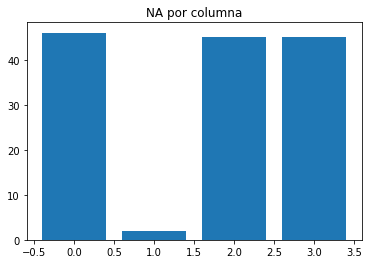

In [ ]:
l = np.zeros(4)
index = 0
for i in df1.columns[1:]:
    l[index] = df1[i].isna().sum()
    index+=1

print(l)
plt.bar(range(4),l)
plt.title('NA por columna')
plt.show()

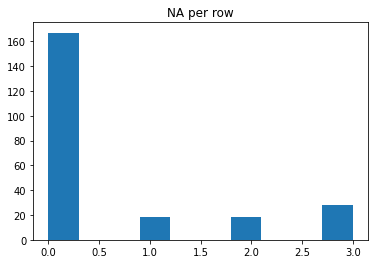

3 NaN per row:  28
Percentage:  12.12 %


In [ ]:
k = len(df1)
l = np.zeros(k)
for i in range(k):
    l[i] = df1.loc[[i]].isna().sum().sum()
plt.hist(l)
plt.title('NA per row')
plt.show()
print("3 NaN per row: ", len(np.where(l == 3)[0]))
print("Percentage: ", np.round(len(np.where(l == 3)[0])/len(df1)*100,2),'%')

In [ ]:
print(len(df1))
#Quitamos las filas con 3 NA
index = np.where(l == 3)[0]
df2 = df1.copy()
df2 = df2[~df2.index.isin(index)]
df2

231


,Timestamp,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia
0,2022-11-23 06:03,-11.717634,2.387277e+00,NaN,NaN
1,2022-11-23 06:04,-11.717634,2.386957e+00,NaN,NaN
2,2022-11-23 06:05,-11.717634,2.386875e+00,NaN,NaN
3,2022-11-23 06:08,-11.717634,2.387250e+00,NaN,NaN
4,2022-11-23 06:09,-11.717634,2.386470e+00,NaN,NaN
...,...,...,...,...,...
205,2022-11-23 09:16,NaN,2.401019e+00,1.200509e+00,5.282242e+02
206,2022-11-23 09:18,NaN,2.401031e+00,1.200586e+00,5.282578e+02
207,2022-11-23 09:25,NaN,2.401172e+00,1.200586e+00,5.282578e+02
208,2022-11-23 10:16,0.000000,1.951564e-19,9.757819e-20,4.293441e-17


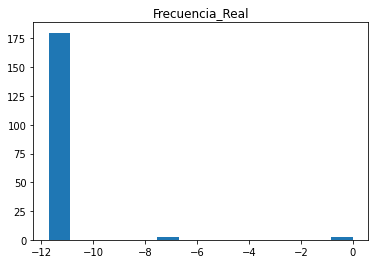

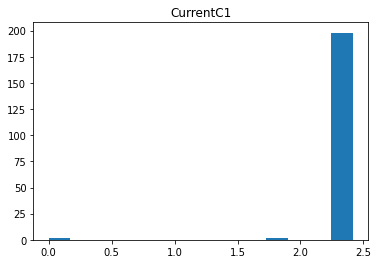

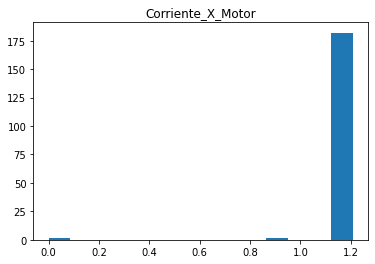

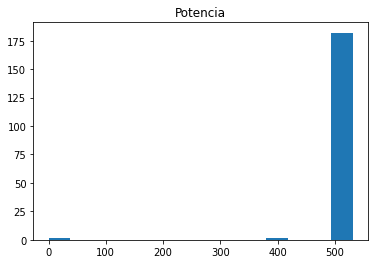

In [ ]:
for i in df2.columns[1:]:
    plt.hist(df2[i], bins=int(np.sqrt(len(df2))))
    plt.title(i)
    plt.show()

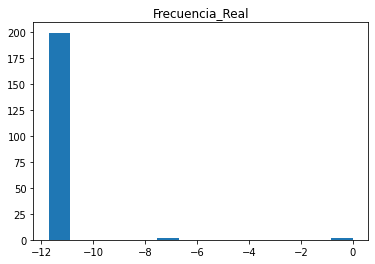

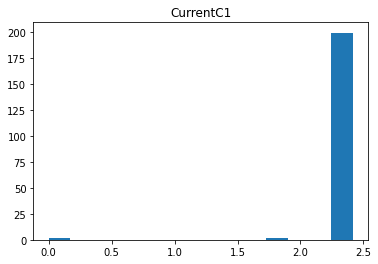

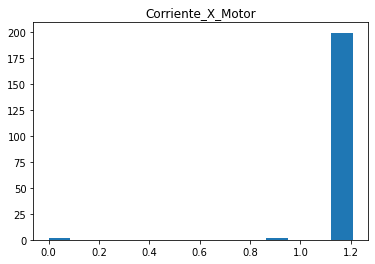

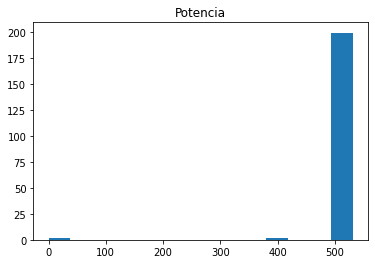

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
df3 = df2.copy().drop(columns = ["Timestamp"])
imputer.fit(df3)
X = imputer.transform(df3)
df3 = pd.DataFrame(X, columns=df3.columns)
for i in df3.columns:
    plt.hist(df3[i], bins=int(np.sqrt(len(df3))))
    plt.title(i)
    plt.show()

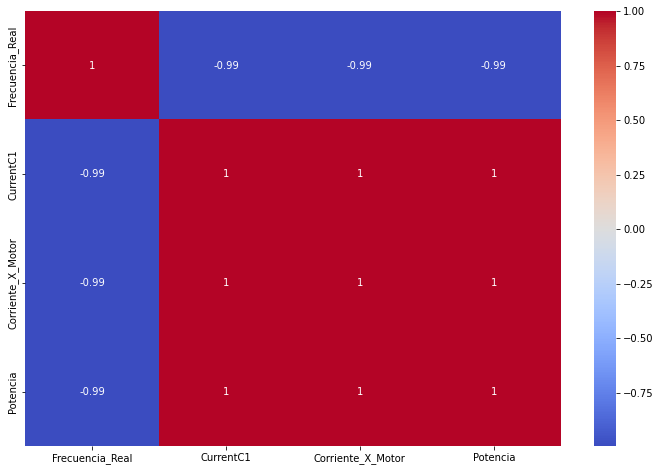

In [ ]:
import seaborn as sns
correlaciones = df3.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(correlaciones, cmap="coolwarm", annot=True)
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, n_init=10)
gm.fit_predict(df3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1])

In [ ]:
gm.converged_

True

In [ ]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
gm.predict(df3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1])

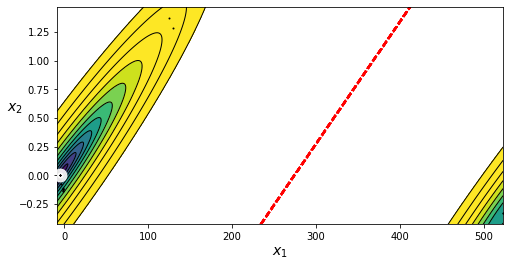

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pca = PCA(n_components = 2)
X2D = pca.fit_transform(df3)
plt.figure(figsize=(8, 4))

gm2 = GaussianMixture(n_components=2, n_init=10, covariance_type="tied")
gm2.fit(X2D)
plot_gaussian_mixture(gm2, X2D)
plt.show()

In [ ]:
densities = gm2.score_samples(X2D)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
print(anomalies)

[[-11.71783765   2.3856618    1.19255024 524.72209821]
 [-11.7176342    2.38309157   1.19154578 524.28013393]
 [-11.7176342    2.38398442   1.19199221 524.4765625 ]
 [-11.71702385   2.38289068   1.19144534 524.2359375 ]
 [-11.71397161   2.3800782    1.1900391  523.6171875 ]
 [-11.7176342    2.38137342   1.19068671 523.90213816]
 [-11.71671867   2.3800782    1.1900391  523.6171875 ]
 [ -7.31550993   1.78528395   0.89264197 392.76246749]
 [ -7.36024272   1.81064212   0.90532106 398.34125926]]


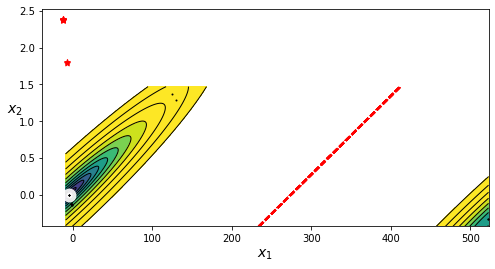

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm2, X2D)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
#plt.ylim(top=5.1)

plt.show()

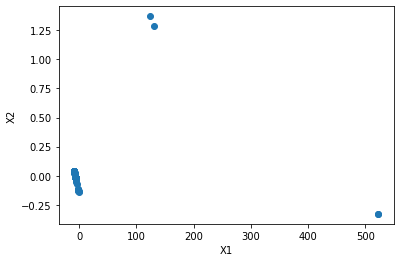

In [ ]:
from sklearn.decomposition import PCA
reduccion = PCA(n_components =  2) #Reduce a dos variables nuevas
df4 = pd.DataFrame(reduccion.fit_transform(df3))
plt.scatter(df4[df4.columns[0]], df4[df4.columns[1]])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [ ]:
from IPython.core.interactiveshell import InteractiveShellABC
from sklearn.cluster import KMeans
agrupamiento = KMeans(n_clusters=3)
df3['grupo'] = agrupamiento.fit_predict(df3)
df3 #Grupo 0 es el primer grupo

,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia,grupo
0,-11.717634,2.387277e+00,1.203398e+00,5.294953e+02,0
1,-11.717634,2.386957e+00,1.203398e+00,5.294953e+02,0
2,-11.717634,2.386875e+00,1.203398e+00,5.294953e+02,0
3,-11.717634,2.387250e+00,1.203398e+00,5.294953e+02,0
4,-11.717634,2.386470e+00,1.203398e+00,5.294953e+02,0
...,...,...,...,...,...
198,-11.717634,2.401019e+00,1.200509e+00,5.282242e+02,0
199,-11.717634,2.401031e+00,1.200586e+00,5.282578e+02,0
200,-11.717634,2.401172e+00,1.200586e+00,5.282578e+02,0
201,0.000000,1.951564e-19,9.757819e-20,4.293441e-17,1


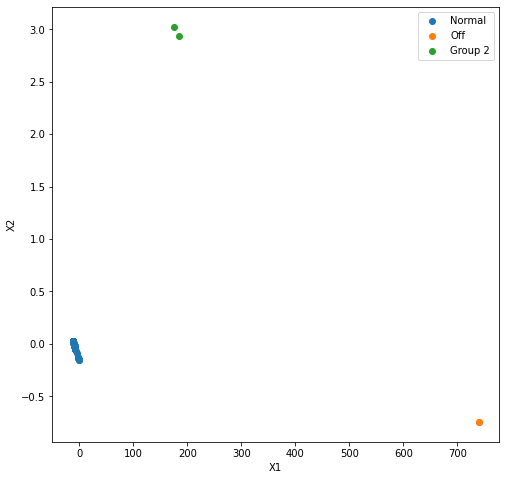

In [ ]:
filtro1 = df3['grupo'] == 0
filtro2 = df3['grupo'] == 1
filtro3 = df3['grupo'] == 2

reduccion = PCA(n_components =  2) #Reduce a dos variables nuevas
df3[['redu1', 'redu2']] = reduccion.fit_transform(df3)

plt.figure(figsize = (8,8))
plt.scatter(df3['redu1'][filtro1], df3['redu2'][filtro1], label = 'Normal')
plt.scatter(df3['redu1'][filtro2], df3['redu2'][filtro2], label = 'Off')
plt.scatter(df3['redu1'][filtro3], df3['redu2'][filtro3], label = 'Group 2')
#Anómalo son los datos de la tarde
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [ ]:
df3[filtro3] #(grupo 2)

,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia,grupo,redu1,redu2
24,-7.315510,1.785284,0.892642,392.762467,2,129.976424,2.074723
25,-7.360243,1.810642,0.905321,398.341259,2,124.398005,2.138466


In [ ]:
df3[filtro2] #Apagado

,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia,grupo,redu1,redu2
201,0.0,1.951564e-19,9.757819e-20,4.293441e-17,1,522.804739,-0.526878
202,0.0,9.757819e-20,4.878910e-20,2.146720e-17,1,522.804739,-0.526878


In [ ]:
df3[filtro1]

,Frecuencia_Real,CurrentC1,Corriente_X_Motor,Potencia,grupo,redu1,redu2
0,-11.717634,2.387277,1.203398,529.495312,0,-6.827652,-0.011079
1,-11.717634,2.386957,1.203398,529.495312,0,-6.827650,-0.011079
2,-11.717634,2.386875,1.203398,529.495312,0,-6.827650,-0.011079
3,-11.717634,2.387250,1.203398,529.495312,0,-6.827652,-0.011079
4,-11.717634,2.386470,1.203398,529.495312,0,-6.827648,-0.011080
...,...,...,...,...,...,...,...
196,-11.717896,2.401491,1.200746,528.328125,0,-5.660850,-0.030540
197,-11.717634,2.401172,1.200586,528.257812,0,-5.590549,-0.031536
198,-11.717634,2.401019,1.200509,528.224185,0,-5.556929,-0.032093
199,-11.717634,2.401031,1.200586,528.257812,0,-5.590548,-0.031536


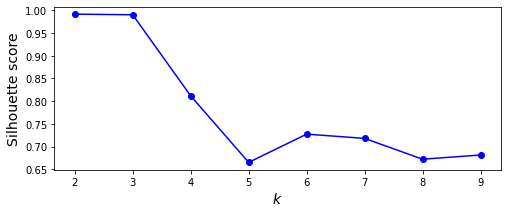

In [ ]:
from sklearn.metrics import silhouette_score

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()


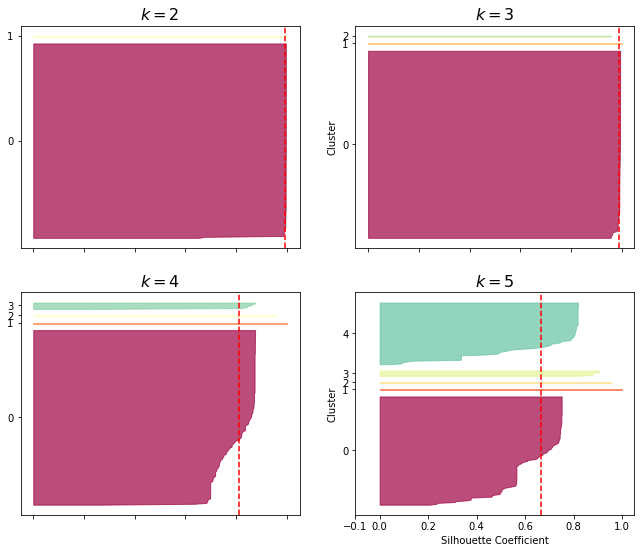

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (2 ,3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [ ]:
from numpy.random import RandomState
def separacionDatos(X,y, s= 0.5,r = 32, t = 3):
    #Aplica sólo para clasificación binaria
    #X son todos los features, y todas las categorías, s indica qué porcentaje del total de
    #las fallas (1) queremos tener en el train set, y r la semilla random, esto para garantizar la 
    #reproducibilidad


    rs = RandomState(r) #Iniciamos semilla
    index = y[y[y.columns[0]] == 1].index
    c = round(len(index)*s) #Cuenta cuántos datos sacaremos con 1
    cc = len(index) - 2*c #Para dividir el set completo
    if cc == 0:
      cc = t
    ran_index = rs.choice(index, c) #Saca c índices de manera aleatoria de todos los que tienen y = 1

    #Extraemos datos
    X_train = X.filter(items = ran_index, axis = 0) 
    y_train = y.filter(items = ran_index, axis = 0)
    ran_index = list(ran_index)

    #Pasamos los que faltan al test
    index1 = [i for i in list(index) if i not in ran_index]
    X_test = X.filter(items = index1, axis = 0)
    y_test = y.filter(items = index1, axis = 0)
    X = X.drop(index)
    y = y.drop(index)

    #Rellenamos ahora con los 2
    index = y[y[y.columns[0]] == 2].index
    ran_index = rs.choice(index, c) #Saca c índices de manera aleatoria de todos los que tienen y = 1

    X_train = pd.merge(X_train, X.filter(items = ran_index, axis = 0) , how = 'outer', on=list(X.columns))
    y_train = pd.merge(y_train, y.filter(items = ran_index, axis = 0), how = 'outer', on=list(y.columns))
    
    ran_index = list(ran_index)
    index1 = [i for i in list(index) if i not in ran_index]

    X_test = pd.merge(X_test, X.filter(items = index1, axis = 0), how = 'outer', on=list(X.columns))
    y_test = pd.merge(y_test, y.filter(items = index1, axis = 0), how = 'outer', on=list(y.columns))
    
    X = X.drop(index)
    y = y.drop(index)

    #Rellenamos las particiones
    index = y[y[y.columns[0]] == 0].index
    ran_index = rs.choice(index, cc) 
    X_train = pd.merge(X_train, X.filter(items = ran_index, axis = 0) , how = 'outer', on=list(X.columns))
    y_train = pd.merge(y_train, y.filter(items = ran_index, axis = 0), how = 'outer', on=list(y.columns))
    
    ran_index = list(ran_index)
    index1 = [i for i in list(index) if i not in ran_index]

    X_test = pd.merge(X_test, X.filter(items = index1, axis = 0), how = 'outer', on=list(X.columns))
    y_test = pd.merge(y_test, y.filter(items = index1, axis = 0), how = 'outer', on=list(y.columns))
    return(pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(y_train).values.ravel(), pd.DataFrame(y_test).values.ravel())


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'C': 1}
LogisticRegression(C=1, max_iter=1000, multi_class='multinomial')
Matrices de confusión: 
[[[  2   0]
  [  0 196]]

 [[197   0]
  [  0   1]]

 [[197   0]
  [  0   1]]]
Promedio de matrices de confusión: 
[[132.   0.]
 [  0.  66.]]
Accuracy 	 Recall
Precision 	 F1
[[1. 1.]
 [1. 1.]]


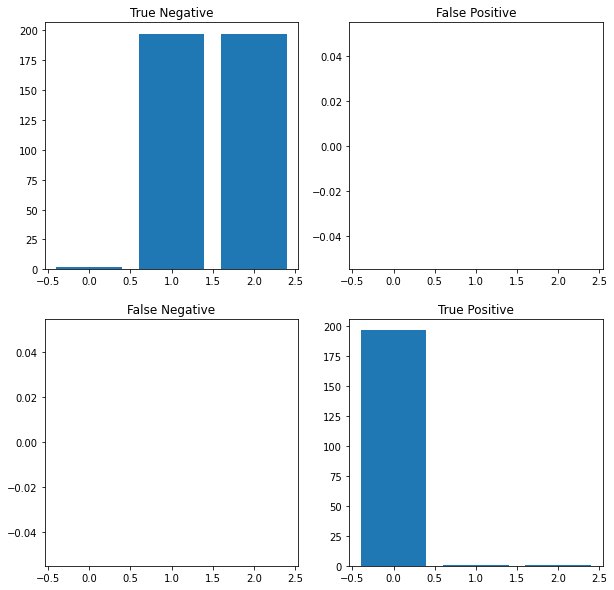

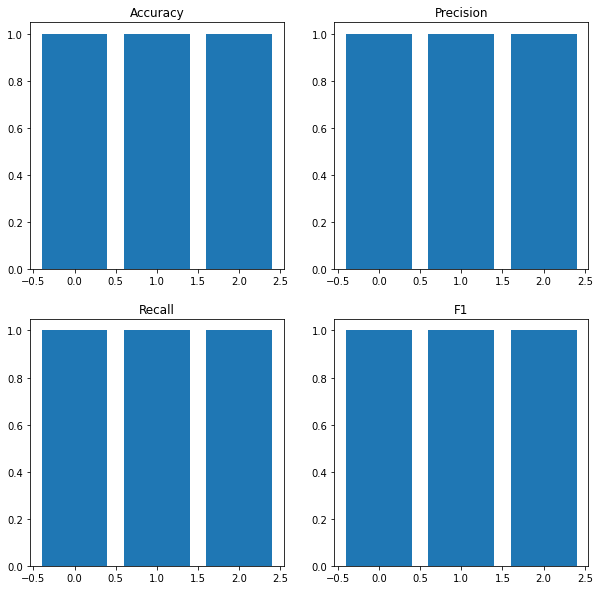

In [ ]:
from sklearn.linear_model import LogisticRegression as LG
datos = df3.copy()
X = datos[["redu1", "redu2"]]
y = datos[["grupo"]]
lg = LG(max_iter = 1000, multi_class = 'multinomial')

valid = Algoritmo(lg,X,y)

X_train, X_test, y_train, y_test = separacionDatos(X,y, s = 0.5)
#lg.fit(X_train, y_train)
#final_pred = lg.predict(X_test)
param_grid = [{'C': [i for i in range(1,101,10)]}] #Cambiar los valores del range
final_pred = valid.hpTunningGSCV(LG(max_iter=1000, multi_class = 'multinomial')
            ,param_grid,X_train,y_train, X_test,name = 'modelo final', CV = 3)
valid.evaluacionClasificacionMulti(y_test = y_test, final_pred = final_pred,
                                   labs = [0, 1, 2]) #Imprime matriz de confusión



In [ ]:
y_train

array([1, 2, 0, 0, 0], dtype=int32)

In [ ]:
y_test

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
final_pred

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)